## Implement BERTopic Modelling

In [ ]:
## Import libraries and packages

In [44]:
#!pip install nltk
#!pip install wordcloud
#!pip install rake_nltk
#!pip install plotly
#!pip install nltools
#!pip install sklearn
#!pip install scipy
#!pip install numpy
!pip install rake-nltk

#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [65]:
### Implement BERToping
import warnings
import numpy as np
import nltk
import plotly.graph_objects as go
import pandas as pd
from nltools.data import Brain_Data, Adjacency
from sklearn.metrics import pairwise_distances
from scipy.stats import rankdata
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from rake_nltk import Rake
from nltk.util import ngrams

warnings.filterwarnings("ignore")

In [66]:
# import text story:
story = pd.read_csv("/home/jovyan/test/mediumposts/natural_language_processing/topic_modeling/sentence_labels.csv")
story

,Unnamed: 0,run,sentence,sentence_offset_runsconcatenated,sentence_offset_inrun,mentalizing_event,sentiment
0,0,story1,The email came late one afternoon as Dr Carmen...,11,11,0,0.000000
1,1,story1,It had been a long day at the busy clinic in C...,18,18,0,-0.083333
2,2,story1,But the email’s strange subject line caught he...,23,23,0,-0.111111
3,3,story1,"“Fellow doctor, I need your help.”",26,26,1,0.333333
4,4,story1,It was sent by someone named Dr John Torreson.,29,29,0,0.000000
...,...,...,...,...,...,...,...
241,241,story3,But another part of her felt wracked with guil...,1289,311,0,-0.150000
242,242,story3,"Carmen pictured Alba’s wide, trusting eyes;",1293,315,0,0.000000
243,243,story3,"If she left now, the decision would haunt her ...",1297,319,0,-0.076923
244,244,story3,"On the other hand, she wasn’t even sure if the...",1305,327,0,-0.041667


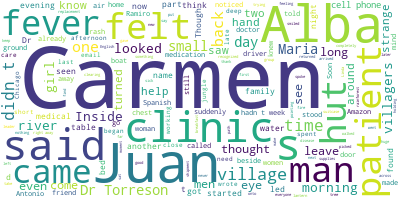

In [67]:
# Join the different processed titles together.
long_string = ','.join(list(story['sentence'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [68]:
# Preprocessing text:
# remove punctuation
story['sentence_preprocessed'] = story['sentence'].str.lower().str.replace('[^\w\s]', ' ').str.replace(' +', ' ').str.strip()

# tokenise string
story['sentence_preprocessed'] = story.apply(lambda row: nltk.word_tokenize(row['sentence_preprocessed']), axis=1)

# initiate stopwords from nltk
stop_words = stopwords.words('english')

# add additional missing terms
stop_words.extend(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m','n','o','p','q','r','s','t', 'u', 'v', 'w', 'x', 'y', 'z', "about", "across", "after", "all", "also", "an", "and", "another", "added",
"any", "are", "as", "at", "basically", "be", "because", 'become', "been", "before", "being", "between","both", "but", "by","came","can","come","could","did","do","does","each","else","every","either","especially", "for","from","get","given","gets",
'give','gives',"got","goes","had","has","have","he","her","here","him","himself","his","how","if","in","into","is","it","its","just","lands","like","make","making", "made", "many","may","me","might","more","most","much","must","my","never","provide", 
"provides", "perhaps","no","now","of","on","only","or","other", "our","out","over","re","said","same","see","should","since","so","some","still","such","seeing", "see", "take","than","that","the","their","them","then","there",
"these","they","this","those","through","to","too","under","up","use","using","used", "underway", "very","want","was","way","we","well","were","what","when","where","which","while","whilst","who","will","with","would","you","your", 
'etc', 'via', 'eg']) 

# remove stopwords
story['sentence_preprocessed'] = story['sentence_preprocessed'].apply(lambda x: [item for item in x if item not in stop_words])

display(story.head(10))

,Unnamed: 0,run,sentence,sentence_offset_runsconcatenated,sentence_offset_inrun,mentalizing_event,sentiment,sentence_preprocessed
0,0,story1,The email came late one afternoon as Dr Carmen...,11,11,0,0.000000,"[email, late, one, afternoon, dr, carmen, reed..."
1,1,story1,It had been a long day at the busy clinic in C...,18,18,0,-0.083333,"[long, day, busy, clinic, chicago, worked, car..."
2,2,story1,But the email’s strange subject line caught he...,23,23,0,-0.111111,"[email, strange, subject, line, caught, eye]"
3,3,story1,"“Fellow doctor, I need your help.”",26,26,1,0.333333,"[fellow, doctor, need, help]"
4,4,story1,It was sent by someone named Dr John Torreson.,29,29,0,0.000000,"[sent, someone, named, dr, john, torreson]"
5,5,story1,"Intrigued, Carmen began to read.",32,32,0,0.000000,"[intrigued, carmen, began, read]"
6,6,story1,Dr Torreson said he was a classmate of Carmen’...,38,38,0,0.000000,"[dr, torreson, classmate, carmen, medical, sch..."
7,7,story1,She didn’t recognize his name — but then again...,42,42,1,0.214286,"[recognize, name, great, names]"
8,8,story1,Dr Torreson had spent the last two years worki...,55,55,0,0.000000,"[dr, torreson, spent, last, two, years, workin..."
9,9,story1,"But, Dr Torreson wrote, he needed to return to...",61,61,0,0.062500,"[dr, torreson, wrote, needed, return, united, ..."


In [69]:
# initiate nltk lemmatiser
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words
story['sentence_preprocessed'] = story['sentence_preprocessed'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

display(story.head(10))

,Unnamed: 0,run,sentence,sentence_offset_runsconcatenated,sentence_offset_inrun,mentalizing_event,sentiment,sentence_preprocessed
0,0,story1,The email came late one afternoon as Dr Carmen...,11,11,0,0.000000,"[email, late, one, afternoon, dr, carmen, reed..."
1,1,story1,It had been a long day at the busy clinic in C...,18,18,0,-0.083333,"[long, day, busy, clinic, chicago, worked, car..."
2,2,story1,But the email’s strange subject line caught he...,23,23,0,-0.111111,"[email, strange, subject, line, caught, eye]"
3,3,story1,"“Fellow doctor, I need your help.”",26,26,1,0.333333,"[fellow, doctor, need, help]"
4,4,story1,It was sent by someone named Dr John Torreson.,29,29,0,0.000000,"[sent, someone, named, dr, john, torreson]"
5,5,story1,"Intrigued, Carmen began to read.",32,32,0,0.000000,"[intrigued, carmen, began, read]"
6,6,story1,Dr Torreson said he was a classmate of Carmen’...,38,38,0,0.000000,"[dr, torreson, classmate, carmen, medical, sch..."
7,7,story1,She didn’t recognize his name — but then again...,42,42,1,0.214286,"[recognize, name, great, name]"
8,8,story1,Dr Torreson had spent the last two years worki...,55,55,0,0.000000,"[dr, torreson, spent, last, two, year, working..."
9,9,story1,"But, Dr Torreson wrote, he needed to return to...",61,61,0,0.062500,"[dr, torreson, wrote, needed, return, united, ..."


In [70]:
# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
                            
# join the processed data to be vectorised
vectors = []

for index, row in story.iterrows():
    vectors.append(", ".join(row['sentence_preprocessed']))

vectorised = vectorizer.fit_transform(vectors)

In [71]:
# Fit LDA Model 
pre_defined_num_topics = 3

# initisalise LDA Model
lda_model = LatentDirichletAllocation(n_components = pre_defined_num_topics, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names
topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document
dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes
story = pd.merge(story, df_document_topic, left_index = True, right_index = True, how = 'outer')

story.to_csv('/home/jovyan/test/mediumposts/natural_language_processing/topic_modeling/BERTopic-modelling_result.csv') 

In [72]:
# Find keywords:
keywords = np.array(vectorizer.get_feature_names())

topic_keywords = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:20]
    topic_keywords.append(keywords.take(top_keyword_locs))

for i in topic_keywords:
    print(i)

['carmen' 'alba' 'man' 'phone' 'girl' 'river' 'hut' 'cell phone' 'cell'
 'juan' 'clinic' 'long' 'dr' 'turned' 'morning' 'woman' 'dr torreson'
 'torreson' 'day' 'night']
['carmen' 'juan' 'patient' 'clinic' 'village' 'felt' 'time' 'alba' 'men'
 'villager' 'one' 'day' 'even' 'maria' 'inside' 'strange' 'saw' 'hut' 'dr'
 'fever']
['carmen' 'alba' 'fever' 'felt' 'back' 'torreson' 'dr' 'part'
 'dr torreson' 'small' 'called' 'juan' 'know' 'started' 'ground' 'thought'
 'eye' 'though' 'around' 'two']


In [73]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Term '+ str(i) for i in range(1, df_topic_keywords.shape[1] + 1)]
df_topic_keywords['Topic_keywords'] = df_topic_keywords.values.tolist()
df_topic_keywords['Topic_number'] = df_topic_keywords.index + 1
df_topic_keywords = df_topic_keywords[['Topic_keywords', 'Topic_number']]

# Remove None from lists
tmp = []

for i in df_topic_keywords['Topic_keywords']:
    tmp.append([x for x in i if x is not None])

df_topic_keywords['Topic_keywords'] = tmp

# Merge key terms back to main frame
df = pd.merge(story, df_topic_keywords, left_on='Dominant_topic', right_on='Topic_number')
del df['Topic_number']

display(df.head(5))

,Unnamed: 0,run,sentence,sentence_offset_runsconcatenated,sentence_offset_inrun,mentalizing_event,sentiment,sentence_preprocessed,Topic1,Topic2,Topic3,Dominant_topic,Topic_keywords
0,0,story1,The email came late one afternoon as Dr Carmen...,11,11,0,0.000000,"[email, late, one, afternoon, dr, carmen, reed...",0.98,0.01,0.01,1,"[carmen, alba, man, phone, girl, river, hut, c..."
1,1,story1,It had been a long day at the busy clinic in C...,18,18,0,-0.083333,"[long, day, busy, clinic, chicago, worked, car...",0.97,0.02,0.02,1,"[carmen, alba, man, phone, girl, river, hut, c..."
2,6,story1,Dr Torreson said he was a classmate of Carmen’...,38,38,0,0.000000,"[dr, torreson, classmate, carmen, medical, sch...",0.94,0.03,0.03,1,"[carmen, alba, man, phone, girl, river, hut, c..."
3,9,story1,"But, Dr Torreson wrote, he needed to return to...",61,61,0,0.062500,"[dr, torreson, wrote, needed, return, united, ...",0.96,0.02,0.02,1,"[carmen, alba, man, phone, girl, river, hut, c..."
4,11,story1,"Even if Carmen could spare a couple of months,...",77,77,1,0.133333,"[even, carmen, spare, couple, month, enormous,...",0.95,0.03,0.03,1,"[carmen, alba, man, phone, girl, river, hut, c..."


In [74]:
all_results = []

for i in df['Dominant_topic'].unique():
    topic = df[df['Dominant_topic'] == i]
    topic = topic.copy()
    
    # remove punctuation 
    topic['sentence'] = topic['sentence'].str.lower().str.replace('[^\w\s]', ' ').str.replace(' +', ' ').str.strip()

    key_words = []
    
    # run keyword extraction
    for j in topic['sentence'].values.tolist():
        r = Rake()
        a = r.extract_keywords_from_text(j)
        c = r.get_ranked_phrases_with_scores()

        for k in c:
            if k not in key_words:
                key_words.append(k)

    key_words = pd.DataFrame(key_words, columns =['score', 'term'])  
    key_words = key_words.sort_values('score', ascending=False)
    key_words = key_words.drop_duplicates(subset=['term'])
    key_words['topic_number'] = i
    
    key_words['term_list'] =  key_words.term.apply(lambda x: x.split())
    
    # find bigrams from key words to match against topic modelling output
    tmp_keywords = []

    for j in key_words.values.tolist():
        tmp = []

        bi_grams = ngrams(j[3], 2)
        
        for g in bi_grams:
            tmp.append(' '.join(g))
        
        for k in j[3]:
            tmp.append(k)
            # lemmatise words to match the lemmatised output of the topic modelling word extraction
            tmp.append(wordnet_lemmatizer.lemmatize(k))
            
        j.remove(j[3])
        j.append(list(set(tmp)))

        tmp_keywords.append(j)
    
    # mask key words against topic modelling output
    key_words = pd.DataFrame(tmp_keywords, columns =['score', 'term', 'topic_number', 'term_list'])  
    
    topic_keywords = topic['Topic_keywords'].values.tolist()
    topic_keywords = [item for sublist in topic_keywords for item in sublist]
    topic_keywords = list(set(topic_keywords))
    
    tmp = []

    for t in topic_keywords:

        mask = key_words.term_list.apply(lambda x: t in x)
        key_words_processed = key_words[mask]

        if key_words_processed.empty:
            pass
        else:
            for j in key_words_processed[['score', 'term', 'topic_number']].values.tolist():
                if j not in tmp:
                    tmp.append(j)

    key_words = pd.DataFrame(tmp, columns =['score', 'term', 'topic_number'])  

    # select the max score as the topic title
    top_key_words = key_words[key_words.score == key_words['score'].max()]

    # select the remaining keywords as child terms
    remaining_keywords = key_words[key_words.score != key_words['score'].max()]
    
    # if there are more than 1 keyword in the topic title, aggregate them with a / as a separatore
    top_key_words = top_key_words.copy()
    top_key_words = top_key_words.groupby(['score', 'topic_number']).agg({'term' : lambda x: ' / '.join(map(str, x))})
    top_key_words = top_key_words.reset_index()
    top_key_words['parent'] = ''

    # add 0.1 to the child keywords to identify then in the merged dataframe
    remaining_keywords = remaining_keywords.copy()
    remaining_keywords['topic_number'] = remaining_keywords['topic_number'] + 0.1
    remaining_keywords['parent'] = top_key_words['term'].values.tolist()[0]
    
    all_topics = pd.concat([top_key_words, remaining_keywords], sort=False)
    
    for t in all_topics.to_dict(orient='records'):
        all_results.append(t)

all_results.append({'score': 1000, 'topic_number' : 0.0, 'term' : '', 'parent' : ''})

all_topics_df = pd.DataFrame(all_results)
all_topics_df = all_topics_df.sort_values('topic_number', ascending=True)
all_topics_df = all_topics_df.loc[all_topics_df['score'] > 10.0]

display(all_topics_df)

,score,topic_number,term,parent
250,1000.0,0.0,,
0,169.0,1.0,saw bed table hut man woman child river tree f...,
54,16.0,1.1,steamy air hit carmen,saw bed table hut man woman child river tree f...
36,25.0,1.1,following morning carmen gave maria,saw bed table hut man woman child river tree f...
8,25.0,1.1,clinic alba would often come,saw bed table hut man woman child river tree f...
15,16.0,1.1,soon antonio turned onto,saw bed table hut man woman child river tree f...
21,16.0,1.1,juan carmen asked holding,saw bed table hut man woman child river tree f...
143,36.0,2.0,men suddenly stopped talking giving carmen,
190,16.0,2.1,replacement shipment juan promised,men suddenly stopped talking giving carmen
185,16.0,2.1,days later carmen saw,men suddenly stopped talking giving carmen


In [75]:
# Topic by TR

# TR for each run
T1 = 526
T2 = 452
T3 = 332

i = 0
ment_r1 = np.zeros(T1)
ment_r2 = np.zeros(T2)
ment_r3 = np.zeros(T3)

sent_label_df = story
sent_label_df_r1 = sent_label_df[sent_label_df['run']=='story1'].reset_index()
sent_label_df_r2 = sent_label_df[sent_label_df['run']=='story2'].reset_index()
sent_label_df_r3 = sent_label_df[sent_label_df['run']=='story3'].reset_index()

In [76]:
i = 0

sent_label_df_r1['sentence_offset_inrun']

ment_r1 = np.zeros(T1)
ment_r2 = np.zeros(T2)
ment_r3 = np.zeros(T3)

for i in range(1,len(sent_label_df_r1['sentence_offset_inrun'])-1):
    ment_r1[sent_label_df_r1['sentence_offset_inrun'].loc[i]:sent_label_df_r1['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r1['Dominant_topic'].loc[i]
    
for i in range(1,len(sent_label_df_r2['sentence_offset_inrun'])-1):
    ment_r2[sent_label_df_r2['sentence_offset_inrun'].loc[i]:sent_label_df_r2['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r2['Dominant_topic'].loc[i]
    
for i in range(1,len(sent_label_df_r3['sentence_offset_inrun'])-1):
    ment_r3[sent_label_df_r3['sentence_offset_inrun'].loc[i]:sent_label_df_r3['sentence_offset_inrun'].loc[i+1]] = sent_label_df_r3['Dominant_topic'].loc[i]


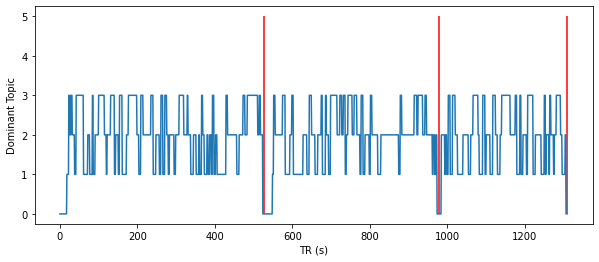

In [77]:
import matplotlib.pyplot as plt
import numpy as np

size = [T1, T2, T3]
time_total = sum(size)

xpoints = np.arange(0, time_total, 1, dtype=int)
ypoints = np.hstack((ment_r1, ment_r2, ment_r3))

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(4)
plt.plot(xpoints, ypoints)

plt.xlabel("TR (s)")
plt.ylabel("Dominant Topic")
#plt.title("Changes in Topic over time")

plt.vlines(x=T1, ymin = -0, ymax=3, colors='red')
plt.vlines(x=T1+T2, ymin = 0, ymax=3, colors='red')
plt.vlines(x=T1+T2+T3, ymin = 0, ymax=3, colors='red')

plt.savefig('FIG-BERTopic_modelling_results.png')
plt.show()

#plt.savefig('BERTopic_modelling_results.png')

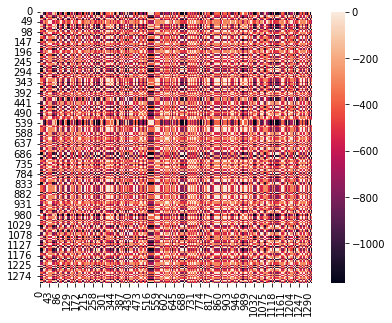

In [59]:
behav_rank = rankdata(ypoints)
behav_sim_nn = Adjacency(pairwise_distances(np.reshape(behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
behav_sim_nn = behav_sim_nn.distance_to_similarity()
behav_sim_nn.plot()